In [ ]:
import torch
from torch import nn
import torch.optim as optim
from torchvision.transforms import ToTensor
import tensorflow as tf

from torch.autograd import Variable
import torch.nn as nn

from tensorflow import keras 

from tensorflow.keras.models import Sequential
from tensorflow.keras import Input, regularizers, layers
from keras.layers import Dense, Dropout, Flatten, LSTM
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import GridSearchCV, KFold, train_test_split,StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score,confusion_matrix
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

In [ ]:
#pip install torch
#pip install torch.nn 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
#calculate standard diviation
def get_standard_diviation(values):
  mean = np.mean(values)
  n = len(values)
  s = np.sqrt(np.sum((values-mean)**2)/(n-1))

  return s

# Get data

In [ ]:
df = pd.read_csv("/content/gdrive/My Drive/Speciale/df_MRI_features_12042022", sep=",", header=0)
df = df.set_index("id")
df = df.drop(["Unnamed: 0"],axis=1)

In [ ]:
#limit amount of features
var_of_interest = ["v1: Femur (vol)","v1: JWS (approx)", "v1: Img Intensity (mean)", "v1: Tibial Intensity (mean)", "v1: Femur Intensity (mean)", 
                   "v1: Miniscus Intensity (mean)", "v1: Entropy Tibial", "v1: Entropy Meniscus","v1: Entropy Femur","v1: Closing Femur","v1: Closing Tibial",
                   "v1: Closing Meniscus","v1: Thick Femur X","v1: Thick Tibial X","v1: Thick Meniscus X",
                   "v2: Femur (vol)","v2: JWS (approx)", "v2: Img Intensity (mean)", "v2: Tibial Intensity (mean)", "v2: Femur Intensity (mean)", 
                   "v2: Miniscus Intensity (mean)", "v2: Entropy Tibial", "v2: Entropy Meniscus","v2: Entropy Femur","v2: Closing Femur","v2: Closing Tibial",
                   "v2: Closing Meniscus","v2: Thick Femur X","v2: Thick Tibial X","v2: Thick Meniscus X",
                   "v3: Femur (vol)","v3: JWS (approx)", "v3: Img Intensity (mean)", "v3: Tibial Intensity (mean)", "v3: Femur Intensity (mean)", 
                   "v3: Miniscus Intensity (mean)", "v3: Entropy Tibial", "v3: Entropy Meniscus","v3: Entropy Femur","v3: Closing Femur","v3: Closing Tibial",
                   "v3: Closing Meniscus","v3: Thick Femur X","v3: Thick Tibial X","v3: Thick Meniscus X", 'y']

df = df[var_of_interest]

#### Seperate data in train and test

In [ ]:
# Get training and validation
TRAIN = pd.read_csv("/content/gdrive/My Drive/Speciale/matched_15032022", sep=",", header=0)
TRAIN = TRAIN.set_index("Unnamed: 0")
TRAIN = TRAIN.index

VAL = pd.read_csv("/content/gdrive/My Drive/Speciale/validation_15032022", sep=",", header=0)
VAL = VAL.set_index("Unnamed: 0")
VAL = VAL.index

In [ ]:
print("All: ", df.shape )

df["id"] = [int(i[:7]) for i in df.index]

# Select validation or training mode VAL or TRAIN
train = df.loc[ df['id'].isin(TRAIN)]
val = df.loc[~df['id'].isin(TRAIN)]

train = train.drop(["id"],axis=1)
val = val.drop(["id"],axis=1)

print("Train", train.shape)
print("Val", val.shape)
train.shape[0]+val.shape[0]

y = train["y"]
train= train.drop(["y"],axis=1)

y_val = val["y"]
val= val.drop(["y"],axis=1)

All:  (1189, 46)
Train (973, 46)
Val (216, 46)


### Split into time stamps

In [ ]:
# find amount of features
n_features=int(len(train.columns)/3)

# split into visits
v1 = np.array(train.iloc[:, :n_features])
v2 = np.array(train.iloc[:, n_features:2*n_features])
v3 = np.array(train.iloc[:, 2*n_features:3*n_features])

# combine and backup
df_all = np.array([v1,v2,v3])
df_all = np.moveaxis(df_all, 0, 1)

df_all1 =df_all.copy()
y1 =y.copy()


## VAL
# find amount of features
n_features=int(len(val.columns)/3)

# split into visits
v1_val = np.array(val.iloc[:, :n_features])
v2_val = np.array(val.iloc[:, n_features:2*n_features])
v3_val = np.array(val.iloc[:, 2*n_features:3*n_features])

# combine and backup
df_all_val = np.array([v1_val,v2_val,v3_val])
df_all_val = np.moveaxis(df_all_val, 0, 1)


# Final Model

(875, 3, 15)
Epoch 1/1000
28/28 [==============================] - 10s 67ms/step - loss: 0.6310 - auc: 0.5492 - val_loss: 0.5993 - val_auc: 0.6027
Epoch 2/1000
28/28 [==============================] - 0s 12ms/step - loss: 0.6335 - auc: 0.5035 - val_loss: 0.5906 - val_auc: 0.4988
Epoch 3/1000
28/28 [==============================] - 0s 12ms/step - loss: 0.6258 - auc: 0.4995 - val_loss: 0.5890 - val_auc: 0.5725
Epoch 4/1000
28/28 [==============================] - 0s 13ms/step - loss: 0.6128 - auc: 0.5134 - val_loss: 0.5845 - val_auc: 0.5711
Epoch 5/1000
28/28 [==============================] - 0s 13ms/step - loss: 0.6090 - auc: 0.5468 - val_loss: 0.5822 - val_auc: 0.5447
Epoch 6/1000
28/28 [==============================] - 0s 12ms/step - loss: 0.6048 - auc: 0.5238 - val_loss: 0.5846 - val_auc: 0.5586
Epoch 7/1000
28/28 [==============================] - 0s 12ms/step - loss: 0.6132 - auc: 0.5113 - val_loss: 0.5767 - val_auc: 0.5629
Epoch 8/1000
28/28 [==============================] - 0

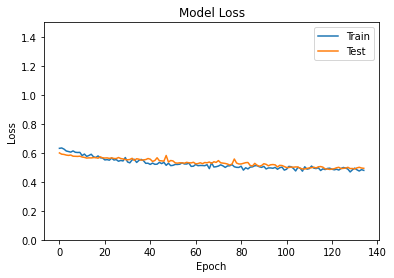

(875, 3, 15)
Epoch 1/1000
28/28 [==============================] - 9s 68ms/step - loss: 0.6489 - auc: 0.5163 - val_loss: 0.5936 - val_auc: 0.4741
Epoch 2/1000
28/28 [==============================] - 0s 13ms/step - loss: 0.6295 - auc: 0.5723 - val_loss: 0.6002 - val_auc: 0.4741
Epoch 3/1000
28/28 [==============================] - 0s 11ms/step - loss: 0.6400 - auc: 0.5295 - val_loss: 0.5925 - val_auc: 0.4785
Epoch 4/1000
28/28 [==============================] - 0s 14ms/step - loss: 0.6344 - auc: 0.5158 - val_loss: 0.5891 - val_auc: 0.4676
Epoch 5/1000
28/28 [==============================] - 0s 13ms/step - loss: 0.6327 - auc: 0.5163 - val_loss: 0.5868 - val_auc: 0.4683
Epoch 6/1000
28/28 [==============================] - 0s 12ms/step - loss: 0.6046 - auc: 0.5763 - val_loss: 0.5855 - val_auc: 0.4701
Epoch 7/1000
28/28 [==============================] - 0s 12ms/step - loss: 0.6017 - auc: 0.5696 - val_loss: 0.5847 - val_auc: 0.4884
Epoch 8/1000
28/28 [==============================] - 0s

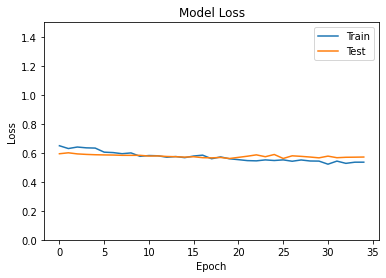

(875, 3, 15)
Epoch 1/1000
28/28 [==============================] - 9s 56ms/step - loss: 0.6634 - auc: 0.5238 - val_loss: 0.5898 - val_auc: 0.5769
Epoch 2/1000
28/28 [==============================] - 0s 12ms/step - loss: 0.6452 - auc: 0.4949 - val_loss: 0.5925 - val_auc: 0.5376
Epoch 3/1000
28/28 [==============================] - 0s 12ms/step - loss: 0.6327 - auc: 0.4984 - val_loss: 0.5881 - val_auc: 0.5556
Epoch 4/1000
28/28 [==============================] - 0s 12ms/step - loss: 0.6242 - auc: 0.5132 - val_loss: 0.5867 - val_auc: 0.5548
Epoch 5/1000
28/28 [==============================] - 0s 12ms/step - loss: 0.6174 - auc: 0.5298 - val_loss: 0.5861 - val_auc: 0.4895
Epoch 6/1000
28/28 [==============================] - 0s 13ms/step - loss: 0.6142 - auc: 0.5409 - val_loss: 0.5844 - val_auc: 0.4875
Epoch 7/1000
28/28 [==============================] - 0s 14ms/step - loss: 0.6117 - auc: 0.5405 - val_loss: 0.5815 - val_auc: 0.5283
Epoch 8/1000
28/28 [==============================] - 0s

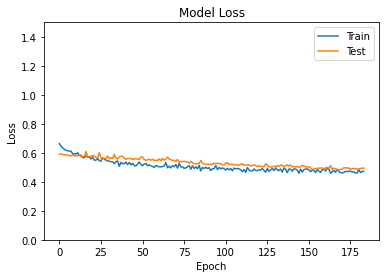

(876, 3, 15)
Epoch 1/1000
28/28 [==============================] - 9s 58ms/step - loss: 0.6743 - auc: 0.4955 - val_loss: 0.5981 - val_auc: 0.4039
Epoch 2/1000
28/28 [==============================] - 0s 11ms/step - loss: 0.6352 - auc: 0.4670 - val_loss: 0.5951 - val_auc: 0.4265
Epoch 3/1000
28/28 [==============================] - 0s 15ms/step - loss: 0.6224 - auc: 0.4876 - val_loss: 0.5926 - val_auc: 0.4836
Epoch 4/1000
28/28 [==============================] - 0s 14ms/step - loss: 0.6012 - auc: 0.5326 - val_loss: 0.5904 - val_auc: 0.5000
Epoch 5/1000
28/28 [==============================] - 0s 13ms/step - loss: 0.6056 - auc: 0.5399 - val_loss: 0.5886 - val_auc: 0.5000
Epoch 6/1000
28/28 [==============================] - 0s 12ms/step - loss: 0.6184 - auc: 0.4789 - val_loss: 0.5863 - val_auc: 0.4872
Epoch 7/1000
28/28 [==============================] - 0s 13ms/step - loss: 0.6098 - auc: 0.4850 - val_loss: 0.5844 - val_auc: 0.4394
Epoch 8/1000
28/28 [==============================] - 0s

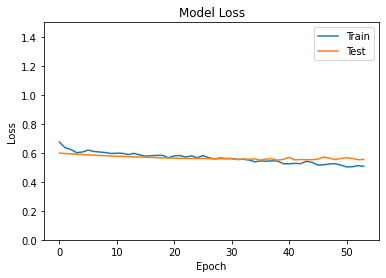

(876, 3, 15)
Epoch 1/1000
28/28 [==============================] - 9s 61ms/step - loss: 0.7263 - auc: 0.4668 - val_loss: 0.6073 - val_auc: 0.4563
Epoch 2/1000
28/28 [==============================] - 0s 12ms/step - loss: 0.6686 - auc: 0.4808 - val_loss: 0.6068 - val_auc: 0.4078
Epoch 3/1000
28/28 [==============================] - 0s 12ms/step - loss: 0.6238 - auc: 0.5466 - val_loss: 0.5975 - val_auc: 0.4233
Epoch 4/1000
28/28 [==============================] - 0s 12ms/step - loss: 0.6554 - auc: 0.4726 - val_loss: 0.5989 - val_auc: 0.4406
Epoch 5/1000
28/28 [==============================] - 0s 14ms/step - loss: 0.6082 - auc: 0.5645 - val_loss: 0.5952 - val_auc: 0.4618
Epoch 6/1000
28/28 [==============================] - 0s 14ms/step - loss: 0.6198 - auc: 0.5354 - val_loss: 0.5958 - val_auc: 0.4676
Epoch 7/1000
28/28 [==============================] - 0s 13ms/step - loss: 0.6046 - auc: 0.5674 - val_loss: 0.5928 - val_auc: 0.4846
Epoch 8/1000
28/28 [==============================] - 0s

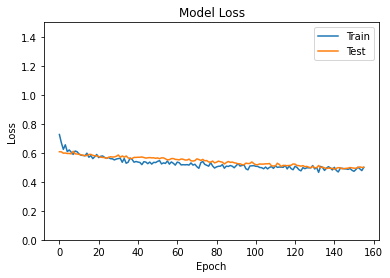

(876, 3, 15)
Epoch 1/1000
28/28 [==============================] - 9s 61ms/step - loss: 0.7427 - auc: 0.4834 - val_loss: 0.6150 - val_auc: 0.4820
Epoch 2/1000
28/28 [==============================] - 0s 13ms/step - loss: 0.6958 - auc: 0.4494 - val_loss: 0.6082 - val_auc: 0.5411
Epoch 3/1000
28/28 [==============================] - 0s 13ms/step - loss: 0.6535 - auc: 0.4969 - val_loss: 0.6000 - val_auc: 0.5708
Epoch 4/1000
28/28 [==============================] - 0s 14ms/step - loss: 0.6373 - auc: 0.5137 - val_loss: 0.5946 - val_auc: 0.5166
Epoch 5/1000
28/28 [==============================] - 0s 13ms/step - loss: 0.6308 - auc: 0.5007 - val_loss: 0.5909 - val_auc: 0.5199
Epoch 6/1000
28/28 [==============================] - 0s 12ms/step - loss: 0.6058 - auc: 0.5485 - val_loss: 0.5883 - val_auc: 0.5041
Epoch 7/1000
28/28 [==============================] - 0s 12ms/step - loss: 0.6270 - auc: 0.4785 - val_loss: 0.5862 - val_auc: 0.5000
Epoch 8/1000
28/28 [==============================] - 0s

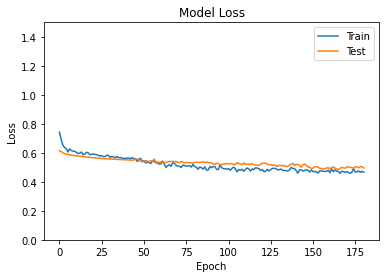

(876, 3, 15)
Epoch 1/1000
28/28 [==============================] - 10s 61ms/step - loss: 0.6888 - auc: 0.4797 - val_loss: 0.6411 - val_auc: 0.4735
Epoch 2/1000
28/28 [==============================] - 0s 12ms/step - loss: 0.6526 - auc: 0.4694 - val_loss: 0.6025 - val_auc: 0.5166
Epoch 3/1000
28/28 [==============================] - 0s 15ms/step - loss: 0.6184 - auc: 0.5129 - val_loss: 0.5932 - val_auc: 0.5955
Epoch 4/1000
28/28 [==============================] - 0s 12ms/step - loss: 0.6168 - auc: 0.5123 - val_loss: 0.5953 - val_auc: 0.6465
Epoch 5/1000
28/28 [==============================] - 0s 12ms/step - loss: 0.6081 - auc: 0.5362 - val_loss: 0.5844 - val_auc: 0.6865
Epoch 6/1000
28/28 [==============================] - 0s 14ms/step - loss: 0.6153 - auc: 0.5014 - val_loss: 0.5903 - val_auc: 0.6844
Epoch 7/1000
28/28 [==============================] - 0s 14ms/step - loss: 0.6035 - auc: 0.5403 - val_loss: 0.5769 - val_auc: 0.7008
Epoch 8/1000
28/28 [==============================] - 0

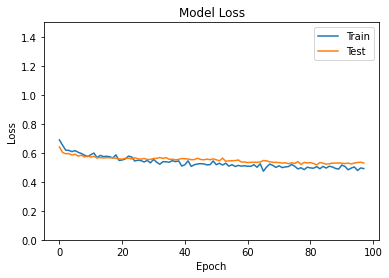

(876, 3, 15)
Epoch 1/1000
28/28 [==============================] - 8s 57ms/step - loss: 0.6597 - auc: 0.4508 - val_loss: 0.6051 - val_auc: 0.5036
Epoch 2/1000
28/28 [==============================] - 0s 12ms/step - loss: 0.6208 - auc: 0.4792 - val_loss: 0.5986 - val_auc: 0.5000
Epoch 3/1000
28/28 [==============================] - 0s 12ms/step - loss: 0.6165 - auc: 0.4722 - val_loss: 0.5942 - val_auc: 0.5000
Epoch 4/1000
28/28 [==============================] - 0s 12ms/step - loss: 0.6068 - auc: 0.5059 - val_loss: 0.5907 - val_auc: 0.4927
Epoch 5/1000
28/28 [==============================] - 0s 12ms/step - loss: 0.5921 - auc: 0.5482 - val_loss: 0.5879 - val_auc: 0.5000
Epoch 6/1000
28/28 [==============================] - 0s 13ms/step - loss: 0.5968 - auc: 0.5256 - val_loss: 0.5854 - val_auc: 0.5000
Epoch 7/1000
28/28 [==============================] - 0s 14ms/step - loss: 0.5865 - auc: 0.5368 - val_loss: 0.5829 - val_auc: 0.5000
Epoch 8/1000
28/28 [==============================] - 0s

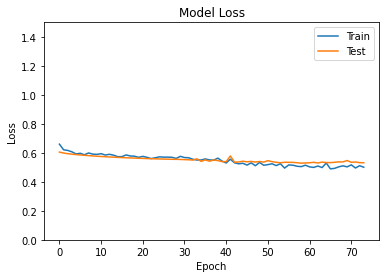

(876, 3, 15)
Epoch 1/1000
28/28 [==============================] - 9s 60ms/step - loss: 0.7026 - auc: 0.4709 - val_loss: 0.4589 - val_auc: 0.6273
Epoch 2/1000
28/28 [==============================] - 0s 13ms/step - loss: 0.6684 - auc: 0.5047 - val_loss: 0.4792 - val_auc: 0.6354
Epoch 3/1000
28/28 [==============================] - 0s 14ms/step - loss: 0.6563 - auc: 0.4962 - val_loss: 0.4764 - val_auc: 0.6154
Epoch 4/1000
28/28 [==============================] - 0s 13ms/step - loss: 0.6436 - auc: 0.5157 - val_loss: 0.4727 - val_auc: 0.6284
Epoch 5/1000
28/28 [==============================] - 0s 15ms/step - loss: 0.6197 - auc: 0.5814 - val_loss: 0.4772 - val_auc: 0.6330
Epoch 6/1000
28/28 [==============================] - 0s 13ms/step - loss: 0.6435 - auc: 0.5017 - val_loss: 0.4782 - val_auc: 0.6046
Epoch 7/1000
28/28 [==============================] - 0s 12ms/step - loss: 0.6168 - auc: 0.5638 - val_loss: 0.4592 - val_auc: 0.5895
Epoch 8/1000
28/28 [==============================] - 0s

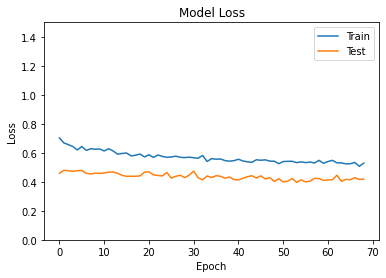

(876, 3, 15)
Epoch 1/1000
28/28 [==============================] - 10s 58ms/step - loss: 0.7555 - auc: 0.4996 - val_loss: 0.4677 - val_auc: 0.5131
Epoch 2/1000
28/28 [==============================] - 0s 14ms/step - loss: 0.7237 - auc: 0.5102 - val_loss: 0.4709 - val_auc: 0.4702
Epoch 3/1000
28/28 [==============================] - 0s 12ms/step - loss: 0.7174 - auc: 0.5217 - val_loss: 0.4837 - val_auc: 0.4709
Epoch 4/1000
28/28 [==============================] - 0s 12ms/step - loss: 0.7136 - auc: 0.5064 - val_loss: 0.4978 - val_auc: 0.5041
Epoch 5/1000
28/28 [==============================] - 0s 15ms/step - loss: 0.7097 - auc: 0.5289 - val_loss: 0.4774 - val_auc: 0.5207
Epoch 6/1000
28/28 [==============================] - 0s 14ms/step - loss: 0.6691 - auc: 0.5345 - val_loss: 0.4837 - val_auc: 0.5126
Epoch 7/1000
28/28 [==============================] - 0s 12ms/step - loss: 0.6890 - auc: 0.4895 - val_loss: 0.4777 - val_auc: 0.5729
Epoch 8/1000
28/28 [==============================] - 0

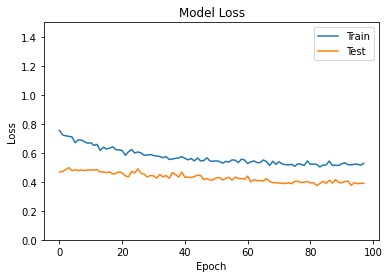

Mean acc:  0.7335384607315063
Confidence interval:  0.06220000907565429
All:  [0.8274521231651306, 0.7293660640716553, 0.7694377899169922, 0.755012571811676, 0.7935464382171631, 0.7581453323364258, 0.7130303382873535, 0.6466666460037231, 0.624848484992981, 0.7178788185119629]


In [ ]:
# define hyperparameters
dropout_rate = 0.25#0.25 
learning_rate = 0.001
recurrent_rate = 0.15 #0.15
l1_rate = 1e-4#-4
l2_rate = 1e-4#-4

#learning_rate = 0.002

n_split = 10
#recurrent_rate=0.3
#dropout_rate=0.3
i=1
preds_stat=np.array([])

skf = StratifiedKFold(n_splits=n_split, shuffle=False)
mean = 0
accuracy = []

for train_index, test_index in skf.split(df_all1, y1):
    Xtrain = df_all[train_index]
    ytrain = y[train_index]
    Xtest = df_all[test_index]
    ytest = y[test_index]
    print(Xtrain.shape)

    inputs = Input(shape=(Xtrain.shape[1], Xtrain.shape[2]))

    model = Sequential()
    x= layers.BatchNormalization(axis=-1,
                                 momentum=0.99,
                                 epsilon=0.0001)(inputs)

    x = layers.Bidirectional(LSTM(10, 
                    activation ="sigmoid",
                    recurrent_activation = "sigmoid",
                    return_sequences=True, 
                    dropout=dropout_rate, 
                    recurrent_dropout=recurrent_rate,
                    kernel_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                    bias_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                    activity_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                    input_shape=(None, Xtrain.shape[1], Xtrain.shape[2])))(x)
    
    x = layers.LSTM(20, 
                    activation ="tanh",
                    recurrent_activation = "softmax",
                    dropout=dropout_rate, 
                    recurrent_dropout=recurrent_rate,
                    kernel_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                    bias_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                    activity_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                    return_sequences=False)(x)

    x= layers.LayerNormalization(  axis=-1,  epsilon=0.001,   center=True,    scale=True)(x)

    x = layers.Dense(20,activation = "relu",
                     kernel_regularizer=regularizers.L1L2(l1_rate,l2_rate))(x)#softmax

    x = layers.LayerNormalization(  axis=-1,  epsilon=0.001,   center=True,    scale=True)(x)
    x = layers.Dropout(dropout_rate) (x)

    x = layers.Dense(5, 
                     kernel_regularizer=regularizers.L1L2(l1_rate,l2_rate), 
                     activation = "softmax")(x)
    
    x = layers.LayerNormalization(  axis=-1,  epsilon=0.001,   center=True,    scale=True)(x)
    x = layers.Dropout(dropout_rate) (x)

    outputs = layers.Dense(1, activation = "sigmoid")(x)  

    model = keras.Model(inputs=inputs, outputs=outputs, name="LSTM_clinical_data")
    
    # define how to compile
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=["AUC"], #,"Recall","accuracy"
        )
    
    history = model.fit(Xtrain, ytrain, epochs=1000, validation_split=0.20, verbose=1, callbacks=EarlyStopping(monitor='val_loss', patience=15), batch_size=25) #batch_size=75,monitor='val_loss'
    
    model.save("/content/gdrive/My Drive/Speciale/imgmodel"+str(i)+".h5")
    i+= 1 

    preds_stat = np.concatenate([preds_stat,np.squeeze(model.predict(Xtest))])

    train_scores = model.evaluate(Xtrain, ytrain, verbose=2)
    test_scores = model.evaluate(Xtest, ytest, verbose=2)
    print("Train loss:", train_scores[0])
    print("Train accuracy:", train_scores[1])
    print("Test loss:", test_scores[0])
    print("Test accuracy:", test_scores[1])
    accuracy.append(test_scores[1])
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title("Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train","Test"],loc="best")
    plt.ylim([0,1.5])
    plt.show()

print("Mean acc: ", np.mean(accuracy))
#create 95% confidence interval for population mean weight
print("Confidence interval: ", get_standard_diviation(accuracy) )
print("All: ", accuracy )

In [ ]:
np.array(y1).tofile("/content/gdrive/My Drive/Speciale/LSTM_mri_y.csv")
preds_stat.tofile("/content/gdrive/My Drive/Speciale/LSTM_mri.csv")


### Validate

In [ ]:
# define hyperparameters
dropout_rate = 0.25#0.25 
learning_rate = 0.001
recurrent_rate = 0.15 #0.15
l1_rate = 1e-4#-4
l2_rate = 1e-4#-4

inputs = Input(shape=(df_all1.shape[1], df_all1.shape[2]))

model = Sequential()
x= layers.BatchNormalization(axis=-1,
                            momentum=0.99,
                            epsilon=0.0001)(inputs)

x = layers.Bidirectional(LSTM(10, 
                activation ="sigmoid",
                recurrent_activation = "sigmoid",
                return_sequences=True, 
                dropout=dropout_rate, 
                recurrent_dropout=recurrent_rate,
                kernel_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                bias_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                activity_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                input_shape=(None, df_all1.shape[1], df_all1.shape[2])))(x)

x = layers.LSTM(20, 
                activation ="tanh",
                recurrent_activation = "softmax",
                dropout=dropout_rate, 
                recurrent_dropout=recurrent_rate,
                kernel_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                bias_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                activity_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                return_sequences=False)(x)

x= layers.LayerNormalization(  axis=-1,  epsilon=0.001,   center=True,    scale=True)(x)

x = layers.Dense(20,activation = "relu",
                kernel_regularizer=regularizers.L1L2(l1_rate,l2_rate))(x)#softmax

x = layers.LayerNormalization(  axis=-1,  epsilon=0.001,   center=True,    scale=True)(x)
x = layers.Dropout(dropout_rate) (x)

x = layers.Dense(5, 
                kernel_regularizer=regularizers.L1L2(l1_rate,l2_rate), 
                activation = "softmax")(x)

x = layers.LayerNormalization(  axis=-1,  epsilon=0.001,   center=True,    scale=True)(x)
x = layers.Dropout(dropout_rate) (x)

outputs = layers.Dense(1, activation = "sigmoid")(x)  

model = keras.Model(inputs=inputs, outputs=outputs, name="LSTM_clinical_data")

# define how to compile
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=["AUC"], #,"Recall","accuracy"
    )

history = model.fit(df_all1, y1, epochs=1000, validation_split=0.20, verbose=1, callbacks=EarlyStopping(monitor='val_loss', patience=15), batch_size=25) 

Epoch 1/1000
32/32 [==============================] - 13s 57ms/step - loss: 0.6979 - auc: 0.4922 - val_loss: 0.6134 - val_auc: 0.5178
Epoch 2/1000
32/32 [==============================] - 1s 16ms/step - loss: 0.6489 - auc: 0.5214 - val_loss: 0.6101 - val_auc: 0.5367
Epoch 3/1000
32/32 [==============================] - 0s 14ms/step - loss: 0.6427 - auc: 0.5123 - val_loss: 0.6083 - val_auc: 0.5111
Epoch 4/1000
32/32 [==============================] - 0s 14ms/step - loss: 0.6235 - auc: 0.5339 - val_loss: 0.6042 - val_auc: 0.5033
Epoch 5/1000
32/32 [==============================] - 0s 13ms/step - loss: 0.6448 - auc: 0.4841 - val_loss: 0.6020 - val_auc: 0.4422
Epoch 6/1000
32/32 [==============================] - 0s 14ms/step - loss: 0.6407 - auc: 0.4714 - val_loss: 0.5999 - val_auc: 0.4806
Epoch 7/1000
32/32 [==============================] - 0s 13ms/step - loss: 0.6182 - auc: 0.5025 - val_loss: 0.5987 - val_auc: 0.4838
Epoch 8/1000
32/32 [==============================] - 0s 13ms/step -

In [ ]:
ypred = model.predict(df_all_val)
print("Accuracy Score: ", roc_auc_score(y_val.astype(float), ypred))

Accuracy Score:  0.8321862348178137


# Shallow model

Epoch 1/1000
28/28 [==============================] - 6s 60ms/step - loss: 1.3649 - auc: 0.4842 - val_loss: 1.2286 - val_auc: 0.5002
Epoch 2/1000
28/28 [==============================] - 0s 9ms/step - loss: 1.1677 - auc: 0.5865 - val_loss: 1.1091 - val_auc: 0.5221
Epoch 3/1000
28/28 [==============================] - 0s 9ms/step - loss: 1.0631 - auc: 0.6318 - val_loss: 1.0172 - val_auc: 0.6493
Epoch 4/1000
28/28 [==============================] - 0s 8ms/step - loss: 0.9806 - auc: 0.6708 - val_loss: 0.9476 - val_auc: 0.6395
Epoch 5/1000
28/28 [==============================] - 0s 8ms/step - loss: 0.9154 - auc: 0.7127 - val_loss: 0.8956 - val_auc: 0.6635
Epoch 6/1000
28/28 [==============================] - 0s 8ms/step - loss: 0.8667 - auc: 0.6920 - val_loss: 0.8555 - val_auc: 0.6859
Epoch 7/1000
28/28 [==============================] - 0s 8ms/step - loss: 0.8281 - auc: 0.6984 - val_loss: 0.8184 - val_auc: 0.6778
Epoch 8/1000
28/28 [==============================] - 0s 8ms/step - loss: 0

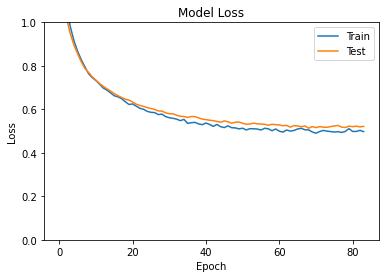

Epoch 1/1000
28/28 [==============================] - 6s 39ms/step - loss: 1.3485 - auc: 0.5441 - val_loss: 1.2557 - val_auc: 0.5804
Epoch 2/1000
28/28 [==============================] - 0s 8ms/step - loss: 1.1585 - auc: 0.6114 - val_loss: 1.1057 - val_auc: 0.6077
Epoch 3/1000
28/28 [==============================] - 0s 8ms/step - loss: 1.0546 - auc: 0.6447 - val_loss: 1.0107 - val_auc: 0.6335
Epoch 4/1000
28/28 [==============================] - 0s 8ms/step - loss: 0.9699 - auc: 0.6868 - val_loss: 0.9403 - val_auc: 0.6432
Epoch 5/1000
28/28 [==============================] - 0s 8ms/step - loss: 0.9027 - auc: 0.7310 - val_loss: 0.8871 - val_auc: 0.6359
Epoch 6/1000
28/28 [==============================] - 0s 8ms/step - loss: 0.8596 - auc: 0.6895 - val_loss: 0.8455 - val_auc: 0.6675
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 0.8189 - auc: 0.7115 - val_loss: 0.8123 - val_auc: 0.6688
Epoch 8/1000
28/28 [==============================] - 0s 9ms/step - loss: 

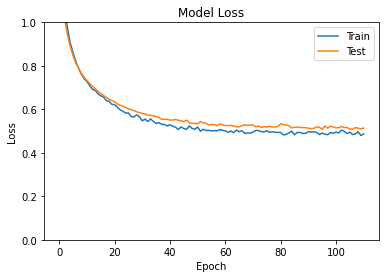

Epoch 1/1000
28/28 [==============================] - 7s 36ms/step - loss: 1.3985 - auc: 0.5311 - val_loss: 1.3346 - val_auc: 0.5462
Epoch 2/1000
28/28 [==============================] - 0s 7ms/step - loss: 1.1652 - auc: 0.6097 - val_loss: 1.1222 - val_auc: 0.4915
Epoch 3/1000
28/28 [==============================] - 0s 8ms/step - loss: 1.0522 - auc: 0.6867 - val_loss: 1.0199 - val_auc: 0.5567
Epoch 4/1000
28/28 [==============================] - 0s 8ms/step - loss: 0.9704 - auc: 0.7156 - val_loss: 0.9484 - val_auc: 0.6018
Epoch 5/1000
28/28 [==============================] - 0s 9ms/step - loss: 0.9090 - auc: 0.6975 - val_loss: 0.8956 - val_auc: 0.6509
Epoch 6/1000
28/28 [==============================] - 0s 9ms/step - loss: 0.8560 - auc: 0.7317 - val_loss: 0.8544 - val_auc: 0.6727
Epoch 7/1000
28/28 [==============================] - 0s 8ms/step - loss: 0.8218 - auc: 0.7131 - val_loss: 0.8217 - val_auc: 0.6764
Epoch 8/1000
28/28 [==============================] - 0s 10ms/step - loss: 

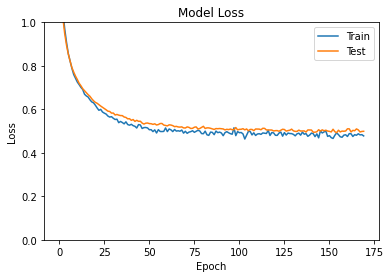

Epoch 1/1000
28/28 [==============================] - 6s 36ms/step - loss: 1.3749 - auc: 0.5181 - val_loss: 1.2531 - val_auc: 0.6354
Epoch 2/1000
28/28 [==============================] - 0s 9ms/step - loss: 1.1733 - auc: 0.5715 - val_loss: 1.1190 - val_auc: 0.6690
Epoch 3/1000
28/28 [==============================] - 0s 8ms/step - loss: 1.0639 - auc: 0.6599 - val_loss: 1.0241 - val_auc: 0.6962
Epoch 4/1000
28/28 [==============================] - 0s 8ms/step - loss: 0.9804 - auc: 0.6818 - val_loss: 0.9512 - val_auc: 0.7227
Epoch 5/1000
28/28 [==============================] - 0s 8ms/step - loss: 0.9151 - auc: 0.6984 - val_loss: 0.8976 - val_auc: 0.7041
Epoch 6/1000
28/28 [==============================] - 0s 8ms/step - loss: 0.8660 - auc: 0.6974 - val_loss: 0.8574 - val_auc: 0.6900
Epoch 7/1000
28/28 [==============================] - 0s 9ms/step - loss: 0.8222 - auc: 0.7159 - val_loss: 0.8205 - val_auc: 0.6948
Epoch 8/1000
28/28 [==============================] - 0s 9ms/step - loss: 0

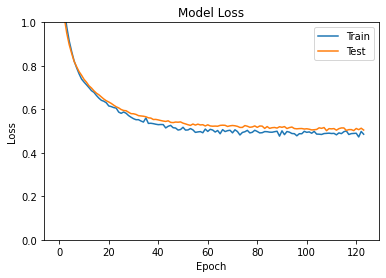

Epoch 1/1000
28/28 [==============================] - 6s 44ms/step - loss: 1.3355 - auc: 0.4810 - val_loss: 1.2535 - val_auc: 0.3199
Epoch 2/1000
28/28 [==============================] - 0s 11ms/step - loss: 1.1625 - auc: 0.5746 - val_loss: 1.1295 - val_auc: 0.4229
Epoch 3/1000
28/28 [==============================] - 0s 12ms/step - loss: 1.0555 - auc: 0.6571 - val_loss: 1.0359 - val_auc: 0.5646
Epoch 4/1000
28/28 [==============================] - 0s 12ms/step - loss: 0.9781 - auc: 0.6592 - val_loss: 0.9667 - val_auc: 0.6069
Epoch 5/1000
28/28 [==============================] - 0s 11ms/step - loss: 0.9108 - auc: 0.7037 - val_loss: 0.9064 - val_auc: 0.6616
Epoch 6/1000
28/28 [==============================] - 0s 11ms/step - loss: 0.8613 - auc: 0.6989 - val_loss: 0.8614 - val_auc: 0.7012
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 0.8256 - auc: 0.6869 - val_loss: 0.8273 - val_auc: 0.7055
Epoch 8/1000
28/28 [==============================] - 0s 9ms/step - l

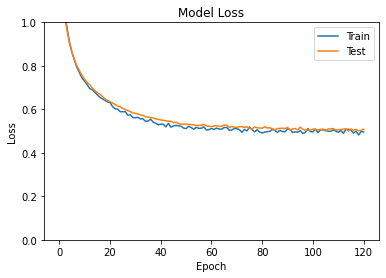

Epoch 1/1000
28/28 [==============================] - 6s 43ms/step - loss: 1.2918 - auc: 0.5339 - val_loss: 1.2234 - val_auc: 0.5995
Epoch 2/1000
28/28 [==============================] - 0s 9ms/step - loss: 1.1500 - auc: 0.6317 - val_loss: 1.1067 - val_auc: 0.6660
Epoch 3/1000
28/28 [==============================] - 0s 8ms/step - loss: 1.0447 - auc: 0.6759 - val_loss: 1.0162 - val_auc: 0.7039
Epoch 4/1000
28/28 [==============================] - 0s 9ms/step - loss: 0.9642 - auc: 0.6906 - val_loss: 0.9484 - val_auc: 0.6998
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 0.9043 - auc: 0.6766 - val_loss: 0.8933 - val_auc: 0.7065
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 0.8536 - auc: 0.7059 - val_loss: 0.8575 - val_auc: 0.6983
Epoch 7/1000
28/28 [==============================] - 0s 11ms/step - loss: 0.8162 - auc: 0.7047 - val_loss: 0.8219 - val_auc: 0.7003
Epoch 8/1000
28/28 [==============================] - 0s 10ms/step - los

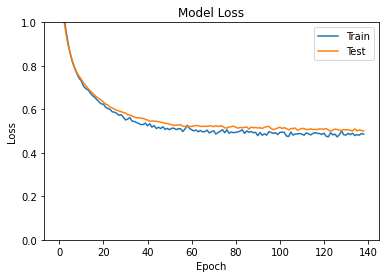

Epoch 1/1000
28/28 [==============================] - 7s 42ms/step - loss: 1.3132 - auc: 0.5503 - val_loss: 1.2645 - val_auc: 0.5517
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 1.1440 - auc: 0.6756 - val_loss: 1.1167 - val_auc: 0.5492
Epoch 3/1000
28/28 [==============================] - 0s 9ms/step - loss: 1.0425 - auc: 0.6932 - val_loss: 1.0192 - val_auc: 0.5717
Epoch 4/1000
28/28 [==============================] - 0s 9ms/step - loss: 0.9631 - auc: 0.7218 - val_loss: 0.9519 - val_auc: 0.5728
Epoch 5/1000
28/28 [==============================] - 0s 9ms/step - loss: 0.9048 - auc: 0.6933 - val_loss: 0.8974 - val_auc: 0.6146
Epoch 6/1000
28/28 [==============================] - 0s 9ms/step - loss: 0.8568 - auc: 0.7116 - val_loss: 0.8621 - val_auc: 0.6336
Epoch 7/1000
28/28 [==============================] - 0s 8ms/step - loss: 0.8166 - auc: 0.7180 - val_loss: 0.8292 - val_auc: 0.6430
Epoch 8/1000
28/28 [==============================] - 0s 8ms/step - loss: 

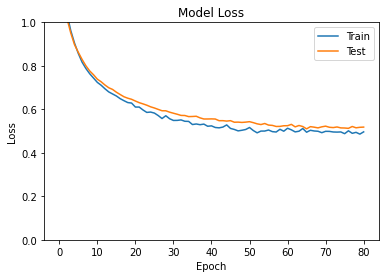

Epoch 1/1000
28/28 [==============================] - 5s 38ms/step - loss: 1.3476 - auc: 0.4903 - val_loss: 1.2452 - val_auc: 0.3747
Epoch 2/1000
28/28 [==============================] - 0s 8ms/step - loss: 1.1648 - auc: 0.5472 - val_loss: 1.1192 - val_auc: 0.4217
Epoch 3/1000
28/28 [==============================] - 0s 8ms/step - loss: 1.0561 - auc: 0.6583 - val_loss: 1.0289 - val_auc: 0.4835
Epoch 4/1000
28/28 [==============================] - 0s 8ms/step - loss: 0.9717 - auc: 0.6979 - val_loss: 0.9627 - val_auc: 0.5315
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 0.9091 - auc: 0.7008 - val_loss: 0.9074 - val_auc: 0.5883
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 0.8561 - auc: 0.7171 - val_loss: 0.8697 - val_auc: 0.6142
Epoch 7/1000
28/28 [==============================] - 0s 9ms/step - loss: 0.8217 - auc: 0.7018 - val_loss: 0.8339 - val_auc: 0.6261
Epoch 8/1000
28/28 [==============================] - 0s 9ms/step - loss:

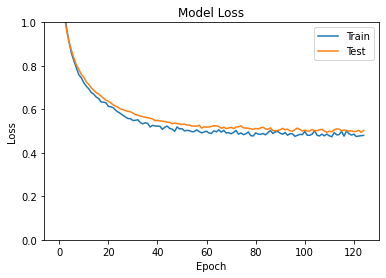

Epoch 1/1000
28/28 [==============================] - 6s 35ms/step - loss: 1.3261 - auc: 0.5551 - val_loss: 1.1813 - val_auc: 0.5823
Epoch 2/1000
28/28 [==============================] - 0s 9ms/step - loss: 1.1841 - auc: 0.6074 - val_loss: 1.0186 - val_auc: 0.6243
Epoch 3/1000
28/28 [==============================] - 0s 8ms/step - loss: 1.0743 - auc: 0.6794 - val_loss: 0.9031 - val_auc: 0.6522
Epoch 4/1000
28/28 [==============================] - 0s 8ms/step - loss: 0.9898 - auc: 0.7113 - val_loss: 0.8212 - val_auc: 0.6557
Epoch 5/1000
28/28 [==============================] - 0s 8ms/step - loss: 0.9287 - auc: 0.7100 - val_loss: 0.7613 - val_auc: 0.6793
Epoch 6/1000
28/28 [==============================] - 0s 8ms/step - loss: 0.8780 - auc: 0.7221 - val_loss: 0.7188 - val_auc: 0.6748
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 0.8427 - auc: 0.7155 - val_loss: 0.6817 - val_auc: 0.6922
Epoch 8/1000
28/28 [==============================] - 0s 13ms/step - loss:

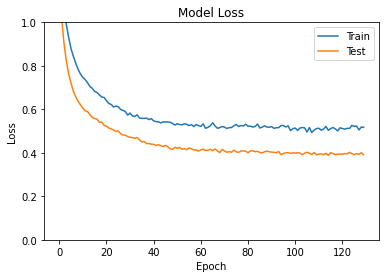

Epoch 1/1000
28/28 [==============================] - 6s 40ms/step - loss: 1.3120 - auc: 0.6004 - val_loss: 1.1874 - val_auc: 0.5537
Epoch 2/1000
28/28 [==============================] - 0s 9ms/step - loss: 1.1657 - auc: 0.6896 - val_loss: 1.0300 - val_auc: 0.5558
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 1.0639 - auc: 0.7097 - val_loss: 0.9164 - val_auc: 0.5678
Epoch 4/1000
28/28 [==============================] - 0s 9ms/step - loss: 0.9896 - auc: 0.6979 - val_loss: 0.8310 - val_auc: 0.6148
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 0.9297 - auc: 0.7019 - val_loss: 0.7677 - val_auc: 0.6517
Epoch 6/1000
28/28 [==============================] - 0s 8ms/step - loss: 0.8824 - auc: 0.7026 - val_loss: 0.7278 - val_auc: 0.6580
Epoch 7/1000
28/28 [==============================] - 0s 9ms/step - loss: 0.8375 - auc: 0.7433 - val_loss: 0.6933 - val_auc: 0.6635
Epoch 8/1000
28/28 [==============================] - 0s 8ms/step - loss:

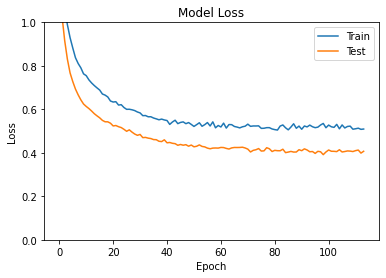

Mean acc:  0.7552674889564515
Confidence interval:  0.04891087915427565
All:  [0.8065191507339478, 0.7592703104019165, 0.7577751278877258, 0.7302631139755249, 0.8377193808555603, 0.7844612002372742, 0.7742424011230469, 0.7239393591880798, 0.7057575583457947, 0.6727272868156433]


In [ ]:
# define hyperparameters
dropout_rate = 0.30 
learning_rate = 0.001 
recurrent_rate = 0.30
n_split=10
#Best : 0.7716447856617028, using {'hidden1': 35, 'l1_rate': 0.0001, 'l2_rate': 0.001, 'learning_rate': 0.001}
l1_rate = 0.0005
l2_rate = 0.005
mean = 0
accuracy = []
preds_stat= np.array([])
i=0

for train_index, test_index in skf.split(df_all1, y1):
    Xtrain = df_all[train_index]
    ytrain = y[train_index]
    Xtest = df_all[test_index]
    ytest = y[test_index]

    model = Sequential()
    x = layers.BatchNormalization(axis=-1,
                                 momentum=0.99,
                                 center =True,
                                 scale = True, 
                                 epsilon=0.0001)(inputs)

    x = layers.Bidirectional(LSTM(30,
                    activation ="sigmoid",
                    recurrent_activation = "sigmoid",
                    return_sequences=False,
                    kernel_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                    bias_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                    activity_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                    dropout=dropout_rate, 
                    recurrent_dropout=recurrent_rate,
                    input_shape=(None, Xtrain.shape[1], Xtrain.shape[2])))(x)

    outputs = layers.Dense(1, activation = "sigmoid")(x)  

    model = keras.Model(inputs=inputs, outputs=outputs, name="LSTM_clinical_data")

    # define how to compile
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=["AUC"], #,"Recall","accuracy"
        )
    
    history = model.fit(Xtrain, ytrain, epochs=1000, validation_split=0.20, verbose=1, callbacks=EarlyStopping(monitor='val_loss', patience=15), batch_size=25) #batch_size=75,monitor='val_loss'
    model.save("/content/gdrive/My Drive/Speciale/imgmodel_shallow"+str(i)+".h5")
    i+= 1 

    preds_stat = np.concatenate([preds_stat,np.squeeze(model.predict(Xtest))])

    train_scores = model.evaluate(Xtrain, ytrain, verbose=2)
    test_scores = model.evaluate(Xtest, ytest, verbose=2)
    print("Train loss:", train_scores[0])
    print("Train accuracy:", train_scores[1])
    print("Test loss:", test_scores[0])
    print("Test accuracy:", test_scores[1])
    accuracy.append(test_scores[1])
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title("Model Loss")
    plt.ylim([0,1.5])
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train","Test"],loc="best")
    plt.ylim([0,1])
    plt.show()

print("Mean acc: ", np.mean(accuracy))
#create 95% confidence interval for population mean weight
print("Confidence interval: ", get_standard_diviation(accuracy) )
print("All: ", accuracy )

In [ ]:
y_pred = model.predict(Xtrain).round()
confusion_matrix(ytrain, y_pred)

array([[670,  11],
       [163,  32]])

In [ ]:
preds_stat.tofile("/content/gdrive/My Drive/Speciale/Shallow_LSTM_mri.csv")


### Validate

In [ ]:
# define hyperparameters
dropout_rate = 0.30 
learning_rate = 0.001 
recurrent_rate = 0.30
n_split=10
#Best : 0.7716447856617028, using {'hidden1': 35, 'l1_rate': 0.0001, 'l2_rate': 0.001, 'learning_rate': 0.001}
l1_rate = 0.0005
l2_rate = 0.005

model = Sequential()
x = layers.BatchNormalization(axis=-1,
                              momentum=0.99,
                              center =True,
                              scale = True, 
                              epsilon=0.0001)(inputs)

x = layers.Bidirectional(LSTM(30,
                activation ="sigmoid",
                recurrent_activation = "sigmoid",
                return_sequences=False,
                kernel_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                bias_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                activity_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                dropout=dropout_rate, 
                recurrent_dropout=recurrent_rate,
                input_shape=(None, df_all.shape[1], df_all.shape[2])))(x)

outputs = layers.Dense(1, activation = "sigmoid")(x)  

model = keras.Model(inputs=inputs, outputs=outputs, name="LSTM_clinical_data")

# define how to compile
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=["AUC"], #,"Recall","accuracy"
    )

history = model.fit(df_all, y, epochs=1000, validation_split=0.20, verbose=1, callbacks=EarlyStopping(monitor='val_loss', patience=15), batch_size=25) #batch_size=75,monitor='val_loss'

In [ ]:
ypred = model.predict(df_all_val)
print("Accuracy Score: ", roc_auc_score(y_val.astype(float), ypred))

# Gidseatch hidden

In [ ]:
dropout_rate = 0.2 #from grid
learning_rate = 0.001 #from grid
recurrent_rate = 0.02

def create_model(hidden1, hidden2, hidden3, hidden4):
    inputs = Input(shape=(Xtrain.shape[1], Xtrain.shape[2]))

    model = Sequential()
    x= layers.BatchNormalization(axis=-1,
                                 momentum=0.99,
                                 epsilon=0.0001)(inputs)

    x = layers.Bidirectional(LSTM(hidden1, 
                    activation ="tanh",
                    recurrent_activation = "sigmoid",
                    return_sequences=True, 
                    dropout=dropout_rate, 
                    recurrent_dropout=recurrent_rate,
                    input_shape=(None, Xtrain.shape[1], Xtrain.shape[2])))(x)
    
    x = layers.LSTM(hidden2, 
                    activation ="tanh",
                    recurrent_activation = "sigmoid",
                    dropout=dropout_rate, 
                    recurrent_dropout=recurrent_rate,
                    return_sequences=False)(x)

    x = layers.Dense(hidden3,activation = "softmax")(x)#softmax
    #x = layers.Dropout(dropout_rate) (x)

    x = layers.Dense(hidden4, activation = "sigmoid")(x)
    #x = layers.Dropout(dropout_rate) (x)

    outputs = layers.Dense(1, activation = "sigmoid")(x)  

    model = keras.Model(inputs=inputs, outputs=outputs, name="LSTM_clinical_data")

    # define how to compile
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=["AUC"], #,"Recall","accuracy"
        )

    return model

model = KerasClassifier(build_fn = create_model,verbose = 2, validation_split=0.20,callbacks=EarlyStopping(monitor='val_loss', patience=20))

In [ ]:
# Define the grid search parameters
n_split = 3
hidden1 = [15, 20] #10
hidden2 = [7, 10 ]
hidden3 = [17] #15
hidden4 = [14, 20]
#Best : 0.7481870052265789, using {'hidden1': 10, 'hidden2': 7, 'hidden3': 15, 'hidden4': 5}
#Best : 0.748312082739404, using {'hidden1': 12, 'hidden2': 7, 'hidden3': 20, 'hidden4': 10}
#Best : 0.743520380839635, using {'hidden1': 15, 'hidden2': 7, 'hidden3': 17, 'hidden4': 15}
#Best : 0.7315071513130874, using {'hidden1': 20, 'hidden2': 7, 'hidden3': 17, 'hidden4': 20}

# Make a dictionary of the grid search parametersparam_grid = dict(batch_size = batch_size,epochs = epochs)
param_grids = dict(hidden1 = hidden1, hidden2=hidden2, hidden3=hidden3, hidden4=hidden4)

# Build and fit the GridSearchCV
grid = GridSearchCV(estimator = model,param_grid = param_grids,cv = StratifiedKFold(n_splits=n_split,random_state=True, shuffle=True),verbose = 3,scoring="roc_auc")
grid_result = grid.fit(df_all1, y1,callbacks=EarlyStopping(monitor='val_loss', patience=25),batch_size = 25, epochs= 1000)

# Summarize the results

print('Best : {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{},{} with: {}'.format(mean, stdev, param))

 #   "Best : 0.7429893676564149, using {'dropout_rate': 0.2, 'learning_rate': 0.001, 'recurrent_rate': 0.2}"

In [ ]:
Best : 0.7315071513130874, using {'hidden1': 20, 'hidden2': 7, 'hidden3': 17, 'hidden4': 20}

# Gidseatch LR + Dropout

In [ ]:
def create_model(learning_rate,dropout_rate,recurrent_rate):
    inputs = Input(shape=(Xtrain.shape[1], Xtrain.shape[2]))

    model = Sequential()
    x= layers.BatchNormalization(axis=-1, momentum=0.99,epsilon=0.0001)(inputs)

    x = layers.Bidirectional(LSTM(10,
                    activation ="tanh",
                    recurrent_activation = "sigmoid",
                    return_sequences=True, 
                    dropout=dropout_rate, 
                    recurrent_dropout=recurrent_rate,
                    input_shape=(None, Xtrain.shape[1], Xtrain.shape[2])))(x)
    
    x = layers.LSTM(20, #Bidirectional(
                    activation ="tanh",
                    recurrent_activation = "sigmoid",
                    return_sequences=False, 
                    recurrent_dropout=recurrent_rate,
                    dropout=dropout_rate)(x)

    x = layers.Dense(75,activation = "softmax")(x)
    x = layers.Dropout(dropout_rate) (x)

    x = layers.Dense(5, activation = "sigmoid")(x)
    x = layers.Dropout(dropout_rate) (x)
      
    outputs = layers.Dense(1, activation = "sigmoid")(x) 

    model = keras.Model(inputs=inputs, outputs=outputs, name="LSTM_clinical_data")

    # define how to compile
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=["AUC"], #,"Recall","accuracy"
        )

    return model

model = KerasClassifier(build_fn = create_model,verbose = 2, validation_split=0.20,callbacks=EarlyStopping(monitor='val_loss', patience=20))

In [ ]:
# Define the grid search parameters
n_split = 3
learning_rate = [0.001,0.0001]
dropout_rate = [0.15, 0.2]
recurrent_rate = [ 0.15,  0.2]

# Make a dictionary of the grid search parametersparam_grid = dict(batch_size = batch_size,epochs = epochs)
param_grids = dict(learning_rate = learning_rate,dropout_rate = dropout_rate, recurrent_rate=recurrent_rate)

# Build and fit the GridSearchCV
grid = GridSearchCV(estimator = model,param_grid = param_grids,cv = StratifiedKFold(n_splits=n_split,random_state=True, shuffle=True),verbose = 3,scoring="roc_auc")
grid_result = grid.fit(df_all1, y1,callbacks=EarlyStopping(monitor='val_loss', patience=25),batch_size = 25, epochs= 1000)

In [ ]:
# Summarize the results

print('Best : {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{},{} with: {}'.format(mean, stdev, param))

    "Best : 0.7429893676564149, using {'dropout_rate': 0.2, 'learning_rate': 0.001, 'recurrent_rate': 0.2}"

In [ ]:
grid_result.cv_results_

# Gidseatch epoch and batch_size

In [ ]:
# Create the model
dropout_rate = 0.2 #from grid
learning_rate = 0.001 #from grid
recurrent_rate = 0.1
n_split = 5

def create_model():
    inputs = Input(shape=(Xtrain.shape[1], Xtrain.shape[2]))

    model = Sequential()
    x= layers.BatchNormalization(axis=-1, momentum=0.99,epsilon=0.0001)(inputs)

    x = layers.Bidirectional(LSTM(10,
                    activation ="tanh",
                    recurrent_activation = "sigmoid",
                    return_sequences=True, 
                    dropout=0.2 , 
                    recurrent_dropout=0.1,
                    input_shape=(None, Xtrain.shape[1], Xtrain.shape[2])))(x)
    
    x = layers.LSTM(7, #Bidirectional(
                    activation ="tanh",
                    recurrent_activation = "sigmoid",
                    return_sequences=False, 
                    recurrent_dropout=0.1,
                    dropout=0.2 )(x)

    x = layers.Dense(15,activation = "softmax")(x)

    x = layers.Dense(5, activation = "sigmoid")(x)
      
    outputs = layers.Dense(1, activation = "sigmoid")(x) 

    model = keras.Model(inputs=inputs, outputs=outputs, name="LSTM_clinical_data")

    # define how to compile
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=["AUC"], #,"Recall","accuracy"
        )

    return model

In [ ]:
# Define the grid search parameters
batch_size = [25,50,100,150,200]
epochs = [500, 700, 1000]

model = KerasClassifier(build_fn = create_model,verbose = 2, validation_split=0.20,callbacks=EarlyStopping(monitor='val_loss', patience=20))

# Make a dictionary of the grid search parameters
param_grid = dict(batch_size = batch_size,epochs = epochs)

# Build and fit the GridSearchCV
grid = GridSearchCV(estimator = model,param_grid = param_grid,cv = StratifiedKFold(n_splits=n_split,random_state=True, shuffle=True),verbose = 3,scoring="roc_auc")
grid_result = grid.fit(df_all1, y1, callbacks=EarlyStopping(monitor='val_loss', patience=25))
#epochs = epochs,batch_size=batch_size,


In [ ]:
# Summarize the results

print('Best : {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{},{} with: {}'.format(mean, stdev, param))

#Best : 0.7631549102935292, using {'batch_size': 25, 'epochs': 1000}

# Gidseatch activation fkt 

In [ ]:
dropout_rate = 0.2 #from grid
learning_rate = 0.001 #from grid
recurrent_rate = 0.02

def create_model(a_fkt1,a_fkt2, a_fkt3, a_fkt4,rea1,rea2):
    inputs = Input(shape=(Xtrain.shape[1], Xtrain.shape[2]))

    model = Sequential()
    x= layers.BatchNormalization(axis=-1, momentum=0.99,epsilon=0.0001)(inputs)

    x = layers.Bidirectional(LSTM(10,
                    activation =a_fkt1,
                    recurrent_activation =rea1,
                    return_sequences=True, 
                    dropout=dropout_rate, 
                    recurrent_dropout=recurrent_rate,
                    input_shape=(None, Xtrain.shape[1], Xtrain.shape[2])))(x)
    
    x = layers.LSTM(20, #Bidirectional(
                    activation =a_fkt2,
                    recurrent_activation =rea2,
                    return_sequences=False, 
                    recurrent_dropout=recurrent_rate,
                    dropout=dropout_rate)(x)
   
    x = layers.Dense(75,activation = a_fkt3)(x)
    x = layers.Dropout(dropout_rate) (x)

    x = layers.Dense(5, activation = a_fkt4)(x)
    x = layers.Dropout(dropout_rate) (x)
      
    outputs = layers.Dense(1, activation = "sigmoid")(x) 

    model = keras.Model(inputs=inputs, outputs=outputs, name="LSTM_clinical_data")

    # define how to compile
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=["AUC"], #,"Recall","accuracy"
        )

    return model

model = KerasClassifier(build_fn = create_model,verbose = 2, validation_split=0.20,callbacks=EarlyStopping(monitor='val_loss', patience=20))

In [ ]:
# Define the grid search parameters
n_split = 3
a_fkt1 = ["sigmoid"]#, "tanh"]
a_fkt2 = ["relu"]#, "tanh"]
a_fkt3 = ["tanh"]#, "tanh"]
a_fkt4 = ["softmax"]#, "tanh"] #relu, softmax, sigmoid
#Best : 0.7721729462121396, using {'a_fkt1': 'sigmoid', 'a_fkt2': 'relu', 'a_fkt3': 'tanh', 'a_fkt4': 'softmax'}
rea1 = ["sigmoid","relu","tanh","softmax"]
rea2 = ["sigmoid","relu","tanh","softmax"]
#softmax sigmoid Best : 0.7557993686228084, using {'a_fkt1': 'sigmoid', 'a_fkt2': 'softmax', 'a_fkt3': 'softmax', 'a_fkt4': 'softmax'}
#softmax tanh Best : 0.7554034995530429, using {'a_fkt1': 'sigmoid', 'a_fkt2': 'softmax', 'a_fkt3': 'softmax', 'a_fkt4': 'softmax'}
#Best : 0.7382980800979281, using {'a_fkt1': 'softmax', 'a_fkt2': 'relu', 'a_fkt3': 'relu', 'a_fkt4': 'softmax'}

# Make a dictionary of the grid search parametersparam_grid = dict(batch_size = batch_size,epochs = epochs)
param_grids = dict(a_fkt1 = a_fkt1, a_fkt2=a_fkt2, a_fkt3=a_fkt3, a_fkt4=a_fkt4, rea1=rea1, rea2=rea2)


# Build and fit the GridSearchCV
grid = GridSearchCV(estimator = model,param_grid = param_grids,cv = StratifiedKFold(n_splits=n_split,random_state=True, shuffle=True),verbose = 3,scoring="roc_auc")
grid_result = grid.fit(df_all1, y1,callbacks=EarlyStopping(monitor='val_loss', patience=25),batch_size = 25, epochs= 1000)


# Summarize the results
print('Best : {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{},{} with: {}'.format(mean, stdev, param))


In [ ]:
 Best : 0.7557993686228084, using {'a_fkt1.2': 'sigmoid', 'a_fkt2.2': 'softmax', 'a_fkt3': 'softmax', 'a_fkt4': 'softmax'}
 Best : 0.7554034995530429, using {'a_fkt1.2': 'sigmoid', 'a_fkt2.2': 'softmax', 'a_fkt3': 'softmax', 'a_fkt4': 'softmax'}
 Best : 0.7382980800979281, using {'a_fkt1': 'softmax', 'a_fkt2': 'relu', 'a_fkt3': 'relu', 'a_fkt4': 'softmax'}
Best : 0.7721729462121396, using {'a_fkt1': 'sigmoid', 'a_fkt2': 'relu', 'a_fkt3': 'tanh', 'a_fkt4': 'softmax'}
Best : 0.7747409360327929, using {'a_fkt1': 'sigmoid', 'a_fkt2': 'relu', 'a_fkt3': 'tanh', 'a_fkt4': 'softmax', 'rea1': 'sigmoid', 'rea2': 'softmax'}

# Gridsearch

In [ ]:

def create_model(hidden1, learning_rate,l1_rate, l2_rate):
    inputs = Input(shape=(Xtrain.shape[1], Xtrain.shape[2]))

    model = Sequential()
    x = layers.BatchNormalization(axis=-1,
                                 momentum=0.99,
                                 center =True,
                                 scale = True, 
                                 epsilon=0.0001)(inputs)
    #x= layers.Flatten()(x)
    
    
    #x = layers.Dropout(dropout_rate) (x)

    x = layers.Bidirectional(LSTM(hidden1,
                    activation ="sigmoid",
                    recurrent_activation = "sigmoid",
                    return_sequences=False,
                    kernel_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                    bias_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                    activity_regularizer=regularizers.L1L2(l1_rate,l2_rate),
                    dropout=dropout_rate, 
                    recurrent_dropout=recurrent_rate,
                    input_shape=(None, Xtrain.shape[1], Xtrain.shape[2])))(x)

    outputs = layers.Dense(1, activation = "sigmoid")(x)  
    
    model = keras.Model(inputs=inputs, outputs=outputs, name="LSTM_clinical_data")

    # define how to compile
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=["AUC"], #,"Recall","accuracy"
        )

    return model

model = KerasClassifier(build_fn = create_model,verbose = 2, validation_split=0.20,callbacks=EarlyStopping(monitor='val_loss', patience=20))

# Define the grid search parameters
n_split = 5
hidden1 = [5, 20 ,35] 
learning_rate =[0.01, 0.001]
l1_rate = [1e-3,1e-4]
l2_rate = [1e-3,1e-4]


# Make a dictionary of the grid search parametersparam_grid = dict(batch_size = batch_size,epochs = epochs)
param_grids = dict(hidden1 = hidden1, learning_rate=learning_rate,l1_rate=l1_rate, l2_rate=l2_rate)

# Build and fit the GridSearchCV
grid = GridSearchCV(estimator = model,param_grid = param_grids,cv = StratifiedKFold(n_splits=n_split,random_state=True, shuffle=True),verbose = 3,scoring="roc_auc")
grid_result = grid.fit(df_all1, y1,callbacks=EarlyStopping(monitor='val_loss', patience=10),batch_size = 35, epochs= 1000)

# Summarize the results
print('Best : {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{},{} with: {}'.format(mean, stdev, param))

In [ ]:

Best : 0.7716447856617028, using {'hidden1': 35, 'l1_rate': 0.0001, 'l2_rate': 0.001, 'learning_rate': 0.001}